In [1]:
import functools
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt


@functools.wraps(smf.ols)
def lm(*args, **kwargs):
    return smf.ols(*args, **kwargs).fit()

In [2]:
raw_df = pd.read_csv("UserAnimeList.csv")

In [3]:
filtered_df = raw_df[["username", "anime_id", "my_score"]].loc[
    lambda x: x["my_score"] != 0
]

In [4]:
def read_xml(file, username):
    import xml.etree.ElementTree as ET

    xml_data = open(file, "r").read()  # Read file
    root = ET.XML(xml_data)  # Parse XML

    data = []
    cols = []
    for i, child in enumerate(root):
        data.append([subchild.text for subchild in child])
        cols.append(child.tag)
    new_list = pd.DataFrame(data).T
    new_list.columns = cols

    df = new_list.loc[[0, 9]].T.dropna().rename({0: "anime_id", 9: "my_score"}, axis=1)
    df["username"] = username
    df["anime_id"] = df["anime_id"].astype(int)
    df["my_score"] = df["my_score"].astype(int)
    df["username"] = df["username"].astype(str)
    df = df.loc[lambda x: x["my_score"] != 0]
    df = df.reset_index(drop=True)
    return df


def add_user(full_df, xml_file, username):
    user_df = read_xml(xml_file, username)
    without_user = full_df.loc[lambda x: x["username"] != username]
    return pd.concat([without_user, user_df], ignore_index=True)

In [5]:
filtered_df = add_user(filtered_df, "user_profiles/Fro116.xml", "Fro116")

In [6]:
average_rating = filtered_df["my_score"].mean()
user_bias = (
    pd.DataFrame(filtered_df.groupby("username")["my_score"].mean()).rename(
        {"my_score": "user_bias"}, axis=1
    )
    - average_rating
)
anime_bias = (
    pd.DataFrame(filtered_df.groupby("anime_id")["my_score"].mean()).rename(
        {"my_score": "anime_bias"}, axis=1
    )
    - average_rating
)

In [7]:
filtered_df = filtered_df.merge(anime_bias, on=["anime_id"]).merge(
    user_bias, on=["username"]
)
filtered_df["normalized_score"] = (
    filtered_df["my_score"]
    - filtered_df["anime_bias"]
    - filtered_df["user_bias"]
    - average_rating
)
filtered_df["orig_normalized_score"] = filtered_df["normalized_score"]
filtered_df = filtered_df.set_index("username")
filtered_df = filtered_df.dropna()

In [8]:
def prepare_prediction(recommendee, neighborhood):
    pred_df = pd.DataFrame()
    pred_df["delta"] = neighborhood.groupby("anime_id").apply(
        lambda x: np.dot(x["normalized_score"], x["corr"]) / x["corr"].abs().sum()
    )
    pred_df["blp"] = anime_bias + user_bias.loc[recommendee].squeeze() + average_rating
    pred_df = pred_df.dropna()
    return pred_df

In [9]:
def get_squared_error(df, pred_df, recommendee):
    recommendee_df = pred_df.loc[
        pred_df.index.intersection(df.loc[recommendee].anime_id)
    ]
    recommendee_df = recommendee_df.merge(
        df.loc[recommendee].set_index("anime_id")["my_score"], on="anime_id"
    )
    errors = recommendee_df["my_score"] - recommendee_df["score"]
    return np.dot(errors, errors)

In [10]:
filtered_df.head()

,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
karthiga,21,9,0.960564,-0.059898,0.605473,0.605473
karthiga,59,7,0.040203,-0.059898,-0.474166,-0.474166
karthiga,74,7,0.316283,-0.059898,-0.750245,-0.750245
karthiga,120,7,0.309858,-0.059898,-0.743821,-0.743821
karthiga,178,7,-0.227338,-0.059898,-0.206624,-0.206624


In [13]:
def compute_accuracy_metrics(
    is_df, oos_df, recommendee, neighborhood_sizes, full_neighborhoods
):

    all_corrs = pickle.load(open("item_correlations/correlations.pkl", "rb"))
    all_corrs["similarity"] = all_corrs["corr"].abs()
    all_corrs = all_corrs.dropna()
    all_corrs = all_corrs.loc[
        lambda x: x.index.get_level_values("anime_id_x")
        != x.index.get_level_values("anime_id_y")
    ]

    anime_var = (
        pd.DataFrame(is_df.groupby("anime_id")["normalized_score"].var())
        .rename({"normalized_score": "anime_var"}, axis=1)
        .dropna()
    )
    user_var = (
        pd.DataFrame(is_df.groupby("username")["normalized_score"].var())
        .rename({"normalized_score": "user_var"}, axis=1)
        .dropna()
    )

    metrics = pd.DataFrame()
    for neighborhood_size in neighborhood_sizes:
        # extract model features
        corrs = all_corrs.copy()
        if full_neighborhoods:
            corrs = corrs.groupby("anime_id_x").apply(
                lambda x: x.sort_values(by="similarity")
            )
        else:
            corrs = corrs.groupby("anime_id_x").apply(
                lambda x: x.sort_values(by="similarity")[-neighborhood_size:]
            )
        corrs.index = corrs.index.droplevel()

        score = is_df.loc[recommendee].merge(
            corrs.reset_index("anime_id_x"), left_on="anime_id", right_on="anime_id_y"
        )
        score["user_var"] = user_var.loc["Fro116"].squeeze()
        score = score.merge(anime_var, on="anime_id")
        score = score.drop("anime_id", axis=1).rename(
            {"anime_id_x": "anime_id"}, axis=1
        )

        if full_neighborhoods:
            score = (
                score.groupby("anime_id")
                .apply(lambda x: x.sort_values(by="similarity")[-neighborhood_size:])
                .reset_index(drop=True)
            )
        pred_df = prepare_prediction(recommendee, score)

        # train linear model
        recomendee_seen_shows = is_df.loc[recommendee].merge(pred_df, on=["anime_id"])
        recomendee_seen_shows["target"] = (
            recomendee_seen_shows["my_score"] - recomendee_seen_shows["blp"]
        )
        model = lm("target ~ delta + 0", recomendee_seen_shows)

        # inference
        pred_df["score"] = model.predict(pred_df) + pred_df["blp"]
        is_pred_df = pred_df.loc[
            lambda x: x.index.isin(is_df.loc[recommendee].anime_id)
        ]
        oos_pred_df = pred_df.loc[lambda x: x.index.isin(oos_df.anime_id)]

        # compute coverage
        is_coverage = len(is_pred_df) / len(is_df.loc[recommendee])
        oos_coverage = len(oos_pred_df) / len(oos_df)

        # compute rmse
        missing_is = is_df.loc[recommendee].loc[
            lambda x: ~x.anime_id.isin(is_pred_df.index)
            & ~x.anime_id.isin(oos_df.anime_id)
        ]
        missing_oos = oos_df.loc[lambda x: ~x.anime_id.isin(oos_pred_df.index)]
        is_se = get_squared_error(is_df, is_pred_df, recommendee)
        oos_se = get_squared_error(oos_df, oos_pred_df, recommendee)
        missing_is_se = np.dot(
            missing_is["orig_normalized_score"], missing_is["orig_normalized_score"]
        )
        missing_oos_se = np.dot(
            missing_oos["orig_normalized_score"], missing_oos["orig_normalized_score"]
        )
        is_rmse = np.sqrt((is_se + missing_is_se) / len(is_df.loc[recommendee]))
        oos_rmse = np.sqrt((oos_se + missing_oos_se) / len(oos_df))
        metrics = metrics.append(
            {
                "neighborhood_size": neighborhood_size,
                "full_neighborhoods": full_neighborhoods,
                "is_rmse": is_rmse,
                "is_coverage": is_coverage,
                "oos_rmse": oos_rmse,
                "oos_coverage": oos_coverage,
            },
            ignore_index=True,
        )
        display(metrics)

    return metrics

In [14]:
%%time
from tqdm import tqdm

recommendee = "Fro116"
K = 10
base = np.sqrt(2)

errors_by_neighborhood_size = []
max_size = len(filtered_df.anime_id.unique())
neighborhood_sizes = [
    int(base ** i) for i in range(int(np.log(max_size) / np.log(base)) + 1)
] + [max_size]
neighborhood_sizes = sorted(list(set(neighborhood_sizes)))
splits = np.array_split(filtered_df.loc[recommendee].sample(frac=1), K)

for split in tqdm(splits):
    oos_df = split
    is_df = filtered_df.loc[
        lambda x: ~(
            (x.index.get_level_values("username") == recommendee)
            & x.anime_id.isin(oos_df.anime_id)
        )
    ]
    # we take copies as a safety precaution
    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(), oos_df.copy(), "Fro116", neighborhood_sizes, False
        )
    )
    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(), oos_df.copy(), "Fro116", neighborhood_sizes, True
        )
    )

  0%|          | 0/10 [00:00<?, ?it/s]

1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
5,0.0,0.821958,1.513065,11.0,0.763158,1.101988
6,0.0,0.848665,1.497088,16.0,0.789474,1.106251
7,0.0,0.875371,1.472172,22.0,0.789474,1.101641
8,0.0,0.881306,1.479543,32.0,0.815789,1.116602
9,0.0,0.884273,1.475050,45.0,0.842105,1.167619


1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.538758,1.0,0.868421,1.165188
1,1.0,0.922849,1.511377,2.0,0.868421,1.095516
2,1.0,0.922849,1.501982,4.0,0.868421,1.169081
3,1.0,0.922849,1.473962,5.0,0.868421,1.233005
4,1.0,0.922849,1.476706,8.0,0.868421,1.119885
5,1.0,0.922849,1.484915,11.0,0.868421,1.099082
6,1.0,0.922849,1.469214,16.0,0.868421,1.122014
7,1.0,0.922849,1.476438,22.0,0.868421,1.124346
8,1.0,0.922849,1.480045,32.0,0.868421,1.199957
9,1.0,0.922849,1.490082,45.0,0.868421,1.186892


 10%|█         | 1/10 [1:33:20<14:00:01, 5600.18s/it]

1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.45928,1.0,0.368421,2.120757


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.459280,1.0,0.368421,2.120757
1,0.0,0.569733,1.462445,2.0,0.631579,2.035798
2,0.0,0.682493,1.429451,4.0,0.684211,2.020471
3,0.0,0.718101,1.451129,5.0,0.736842,1.986620
4,0.0,0.783383,1.418946,8.0,0.868421,1.956511
5,0.0,0.807122,1.404837,11.0,0.894737,1.979326
6,0.0,0.836795,1.397803,16.0,0.921053,1.894568
7,0.0,0.857567,1.383369,22.0,0.921053,1.912082
8,0.0,0.860534,1.392702,32.0,0.921053,1.929351
9,0.0,0.863501,1.384435,45.0,0.921053,1.916390


1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.433288,1.0,0.921053,2.041397
1,1.0,0.916914,1.385547,2.0,0.921053,1.959260
2,1.0,0.916914,1.378007,4.0,0.921053,1.907149
3,1.0,0.916914,1.374541,5.0,0.921053,1.881961
4,1.0,0.916914,1.372989,8.0,0.921053,1.852765
5,1.0,0.916914,1.365752,11.0,0.921053,1.866328
6,1.0,0.916914,1.365092,16.0,0.921053,1.880889
7,1.0,0.916914,1.368119,22.0,0.921053,1.896215
8,1.0,0.916914,1.364959,32.0,0.921053,1.909211
9,1.0,0.916914,1.376370,45.0,0.921053,1.931260


 20%|██        | 2/10 [2:49:18<11:45:00, 5287.58s/it]

1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.397626,1.557213,1.0,0.526316,1.478129
1,0.0,0.543027,1.555222,2.0,0.605263,1.479764
2,0.0,0.673591,1.523577,4.0,0.684211,1.377897
3,0.0,0.706231,1.535845,5.0,0.710526,1.420242
4,0.0,0.795252,1.513086,8.0,0.789474,1.372395
5,0.0,0.818991,1.486038,11.0,0.789474,1.377924
6,0.0,0.845697,1.466706,16.0,0.815789,1.356397
7,0.0,0.869436,1.441045,22.0,0.868421,1.329146
8,0.0,0.878338,1.456766,32.0,0.868421,1.310338
9,0.0,0.881306,1.444658,45.0,0.868421,1.293667


1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.520129,1.0,0.921053,1.391713
1,1.0,0.916914,1.468534,2.0,0.921053,1.302198
2,1.0,0.916914,1.476319,4.0,0.921053,1.309110
3,1.0,0.916914,1.470158,5.0,0.921053,1.312145
4,1.0,0.916914,1.458812,8.0,0.921053,1.305181
5,1.0,0.916914,1.458930,11.0,0.921053,1.317720
6,1.0,0.916914,1.451717,16.0,0.921053,1.259897
7,1.0,0.916914,1.463632,22.0,0.921053,1.242646
8,1.0,0.916914,1.464257,32.0,0.921053,1.247775
9,1.0,0.916914,1.479229,45.0,0.921053,1.241177


 30%|███       | 3/10 [4:05:20<9:51:29, 5069.86s/it] 

1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.451039,1.556377,1.0,0.447368,1.511108
1,0.0,0.587537,1.551621,2.0,0.605263,1.504153
2,0.0,0.700297,1.530829,4.0,0.789474,1.481544
3,0.0,0.732938,1.544416,5.0,0.789474,1.477601
4,0.0,0.801187,1.522048,8.0,0.815789,1.404755
5,0.0,0.821958,1.501245,11.0,0.815789,1.382743
6,0.0,0.845697,1.480881,16.0,0.842105,1.407875
7,0.0,0.872404,1.457602,22.0,0.868421,1.421650
8,0.0,0.878338,1.465596,32.0,0.868421,1.380680
9,0.0,0.881306,1.456236,45.0,0.868421,1.402264


1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.916914,1.535327,1.0,0.921053,1.504381
1,1.0,0.916914,1.485069,2.0,0.921053,1.446977
2,1.0,0.916914,1.483619,4.0,0.921053,1.407794
3,1.0,0.916914,1.480137,5.0,0.921053,1.392383
4,1.0,0.916914,1.453681,8.0,0.921053,1.367916
5,1.0,0.916914,1.462484,11.0,0.921053,1.392252
6,1.0,0.916914,1.452373,16.0,0.921053,1.396136
7,1.0,0.916914,1.444977,22.0,0.921053,1.408265
8,1.0,0.916914,1.461425,32.0,0.921053,1.395350
9,1.0,0.916914,1.458733,45.0,0.921053,1.449756


 40%|████      | 4/10 [5:01:47<7:36:29, 4564.98s/it]

1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.55922,1.0,0.342105,1.490511


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.445104,1.559220,1.0,0.342105,1.490511
1,0.0,0.581602,1.560346,2.0,0.447368,1.492357
2,0.0,0.706231,1.517415,4.0,0.552632,1.525868
3,0.0,0.735905,1.518025,5.0,0.578947,1.532507
4,0.0,0.792285,1.511076,8.0,0.710526,1.513930
5,0.0,0.810089,1.490858,11.0,0.763158,1.440153
6,0.0,0.842730,1.464697,16.0,0.763158,1.489793
7,0.0,0.872404,1.439965,22.0,0.763158,1.474724
8,0.0,0.878338,1.448386,32.0,0.815789,1.472301
9,0.0,0.884273,1.433899,45.0,0.815789,1.531529


1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.922849,1.533182,1.0,0.868421,1.478175
1,1.0,0.922849,1.470937,2.0,0.868421,1.436236
2,1.0,0.922849,1.461873,4.0,0.868421,1.500834
3,1.0,0.922849,1.446961,5.0,0.868421,1.514410
4,1.0,0.922849,1.442320,8.0,0.868421,1.569613
5,1.0,0.922849,1.433053,11.0,0.868421,1.529605
6,1.0,0.922849,1.427090,16.0,0.868421,1.521431
7,1.0,0.922849,1.433892,22.0,0.868421,1.522362
8,1.0,0.922849,1.440931,32.0,0.868421,1.542889
9,1.0,0.922849,1.446979,45.0,0.868421,1.529515


 50%|█████     | 5/10 [5:46:27<5:33:18, 3999.71s/it]

1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.559472,1.0,0.459459,1.520946
1,0.0,0.585799,1.557051,2.0,0.513514,1.527502
2,0.0,0.695266,1.513272,4.0,0.648649,1.504736
3,0.0,0.727811,1.515497,5.0,0.702703,1.500935
4,0.0,0.798817,1.486779,8.0,0.837838,1.544846
5,0.0,0.822485,1.460231,11.0,0.837838,1.529101
6,0.0,0.849112,1.447144,16.0,0.837838,1.526111
7,0.0,0.866864,1.432191,22.0,0.891892,1.489346
8,0.0,0.872781,1.438405,32.0,0.891892,1.512000
9,0.0,0.878698,1.437624,45.0,0.891892,1.489947


1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.517271,1.0,0.945946,1.537521
1,1.0,0.914201,1.463855,2.0,0.945946,1.522705
2,1.0,0.914201,1.450686,4.0,0.945946,1.579996
3,1.0,0.914201,1.452706,5.0,0.945946,1.503119
4,1.0,0.914201,1.445548,8.0,0.945946,1.444084
5,1.0,0.914201,1.444326,11.0,0.945946,1.425154
6,1.0,0.914201,1.441480,16.0,0.945946,1.333999
7,1.0,0.914201,1.448486,22.0,0.945946,1.316964
8,1.0,0.914201,1.448535,32.0,0.945946,1.289977
9,1.0,0.914201,1.461104,45.0,0.945946,1.280519


 60%|██████    | 6/10 [6:30:27<3:59:26, 3591.74s/it]

1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.54571,1.0,0.513514,1.460798


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.428994,1.545710,1.0,0.513514,1.460798
1,0.0,0.571006,1.553336,2.0,0.621622,1.452272
2,0.0,0.713018,1.529059,4.0,0.675676,1.411792
3,0.0,0.742604,1.536867,5.0,0.729730,1.441366
4,0.0,0.807692,1.519530,8.0,0.810811,1.408995
5,0.0,0.828402,1.494783,11.0,0.810811,1.384051
6,0.0,0.855030,1.479730,16.0,0.810811,1.361382
7,0.0,0.866864,1.452041,22.0,0.891892,1.339893
8,0.0,0.875740,1.466326,32.0,0.891892,1.305324
9,0.0,0.878698,1.467734,45.0,0.891892,1.264246


1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.52227,1.0,0.945946,1.49839


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.522270,1.0,0.945946,1.498390
1,1.0,0.914201,1.471725,2.0,0.945946,1.402324
2,1.0,0.914201,1.478780,4.0,0.945946,1.356240
3,1.0,0.914201,1.464754,5.0,0.945946,1.347444
4,1.0,0.914201,1.457276,8.0,0.945946,1.381100
5,1.0,0.914201,1.462060,11.0,0.945946,1.343530
6,1.0,0.914201,1.459549,16.0,0.945946,1.322436
7,1.0,0.914201,1.464720,22.0,0.945946,1.311782
8,1.0,0.914201,1.471121,32.0,0.945946,1.299508
9,1.0,0.914201,1.481990,45.0,0.945946,1.283876


 70%|███████   | 7/10 [7:15:14<2:46:00, 3320.12s/it]

1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.446746,1.587755,1.0,0.459459,1.165295
1,0.0,0.568047,1.590187,2.0,0.594595,1.157868
2,0.0,0.674556,1.555690,4.0,0.783784,1.198048
3,0.0,0.704142,1.569141,5.0,0.810811,1.177230
4,0.0,0.789941,1.552709,8.0,0.864865,1.142905
5,0.0,0.810651,1.518505,11.0,0.891892,1.211236
6,0.0,0.846154,1.499352,16.0,0.891892,1.182183
7,0.0,0.866864,1.472873,22.0,0.891892,1.196983
8,0.0,0.872781,1.475904,32.0,0.891892,1.214453
9,0.0,0.875740,1.473431,45.0,0.891892,1.125947


1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.914201,1.555513,1.0,0.945946,1.179612
1,1.0,0.914201,1.514025,2.0,0.945946,1.174665
2,1.0,0.914201,1.492331,4.0,0.945946,1.121711
3,1.0,0.914201,1.501328,5.0,0.945946,1.093562
4,1.0,0.914201,1.488045,8.0,0.945946,1.033375
5,1.0,0.914201,1.481159,11.0,0.945946,1.044002
6,1.0,0.914201,1.470388,16.0,0.945946,1.081136
7,1.0,0.914201,1.472861,22.0,0.945946,1.069836
8,1.0,0.914201,1.485619,32.0,0.945946,1.061430
9,1.0,0.914201,1.490764,45.0,0.945946,1.049146


 80%|████████  | 8/10 [8:01:09<1:45:01, 3150.83s/it]

1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.434911,1.550484,1.0,0.459459,1.644694
1,0.0,0.568047,1.537931,2.0,0.540541,1.667557
2,0.0,0.689349,1.507185,4.0,0.648649,1.569967
3,0.0,0.718935,1.517391,5.0,0.702703,1.562669
4,0.0,0.789941,1.490731,8.0,0.756757,1.579899
5,0.0,0.810651,1.473444,11.0,0.783784,1.574078
6,0.0,0.834320,1.451714,16.0,0.837838,1.590619
7,0.0,0.857988,1.425072,22.0,0.864865,1.494396
8,0.0,0.869822,1.436988,32.0,0.891892,1.528633
9,0.0,0.872781,1.439892,45.0,0.891892,1.472968


1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.498008,1.0,0.918919,1.628668
1,1.0,0.91716,1.450204,2.0,0.918919,1.491977
2,1.0,0.91716,1.446109,4.0,0.918919,1.478201
3,1.0,0.91716,1.447880,5.0,0.918919,1.528923
4,1.0,0.91716,1.418381,8.0,0.918919,1.547070
5,1.0,0.91716,1.424150,11.0,0.918919,1.566359
6,1.0,0.91716,1.418603,16.0,0.918919,1.644363
7,1.0,0.91716,1.422774,22.0,0.918919,1.675756
8,1.0,0.91716,1.431894,32.0,0.918919,1.677988
9,1.0,0.91716,1.438025,45.0,0.918919,1.701712


 90%|█████████ | 9/10 [8:47:49<50:45, 3045.50s/it]  

1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.58005


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.431953,1.542348,1.0,0.405405,1.580050
1,0.0,0.565089,1.531439,2.0,0.594595,1.650011
2,0.0,0.674556,1.524910,4.0,0.783784,1.580612
3,0.0,0.713018,1.528754,5.0,0.783784,1.620812
4,0.0,0.795858,1.509083,8.0,0.837838,1.540717
5,0.0,0.819527,1.494231,11.0,0.864865,1.487748
6,0.0,0.840237,1.482818,16.0,0.864865,1.476343
7,0.0,0.860947,1.454546,22.0,0.864865,1.487069
8,0.0,0.872781,1.452403,32.0,0.864865,1.517049
9,0.0,0.878698,1.431121,45.0,0.891892,1.515081


1


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213


2


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209


4


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688


5


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583


8


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514


11


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190


16


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519


22


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808


32


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160


45


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


64


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


90


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


128


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


181


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


256


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


362


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


512


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


724


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


1024


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


1448


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


2048


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


2896


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


4096


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


5792


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


8192


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


11585


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


14088


,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,1.0,0.91716,1.534977,1.0,0.918919,1.528213
1,1.0,0.91716,1.497913,2.0,0.918919,1.466209
2,1.0,0.91716,1.477837,4.0,0.918919,1.507688
3,1.0,0.91716,1.460175,5.0,0.918919,1.497583
4,1.0,0.91716,1.437929,8.0,0.918919,1.453514
5,1.0,0.91716,1.436441,11.0,0.918919,1.497190
6,1.0,0.91716,1.433748,16.0,0.918919,1.485519
7,1.0,0.91716,1.427787,22.0,0.918919,1.499808
8,1.0,0.91716,1.437632,32.0,0.918919,1.483160
9,1.0,0.91716,1.440333,45.0,0.918919,1.476816


100%|██████████| 10/10 [9:55:34<00:00, 3573.42s/it]

CPU times: user 6h 33min 23s, sys: 3h 16min 30s, total: 9h 49min 53s
Wall time: 9h 55min 37s


In [15]:
allerrors = pd.concat(errors_by_neighborhood_size, ignore_index=True)

In [16]:
allerrors

,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.433234,1.580479,1.0,0.447368,1.151283
1,0.0,0.575668,1.589632,2.0,0.552632,1.204425
2,0.0,0.700297,1.554716,4.0,0.657895,1.141972
3,0.0,0.738872,1.562947,5.0,0.657895,1.148086
4,0.0,0.807122,1.540329,8.0,0.710526,1.195224
...,...,...,...,...,...,...
535,1.0,0.917160,1.461831,4096.0,0.918919,1.494564
536,1.0,0.917160,1.461831,5792.0,0.918919,1.494564
537,1.0,0.917160,1.461831,8192.0,0.918919,1.494564
538,1.0,0.917160,1.461831,11585.0,0.918919,1.494564


In [21]:
wide_data = pd.melt(allerrors, ["neighborhood_size", "full_neighborhoods"])

In [22]:
wide_data.loc[lambda x: x.full_neighborhoods == True, "variable"] = (
    "full_" + wide_data.loc[lambda x: x.full_neighborhoods == True, "variable"]
)

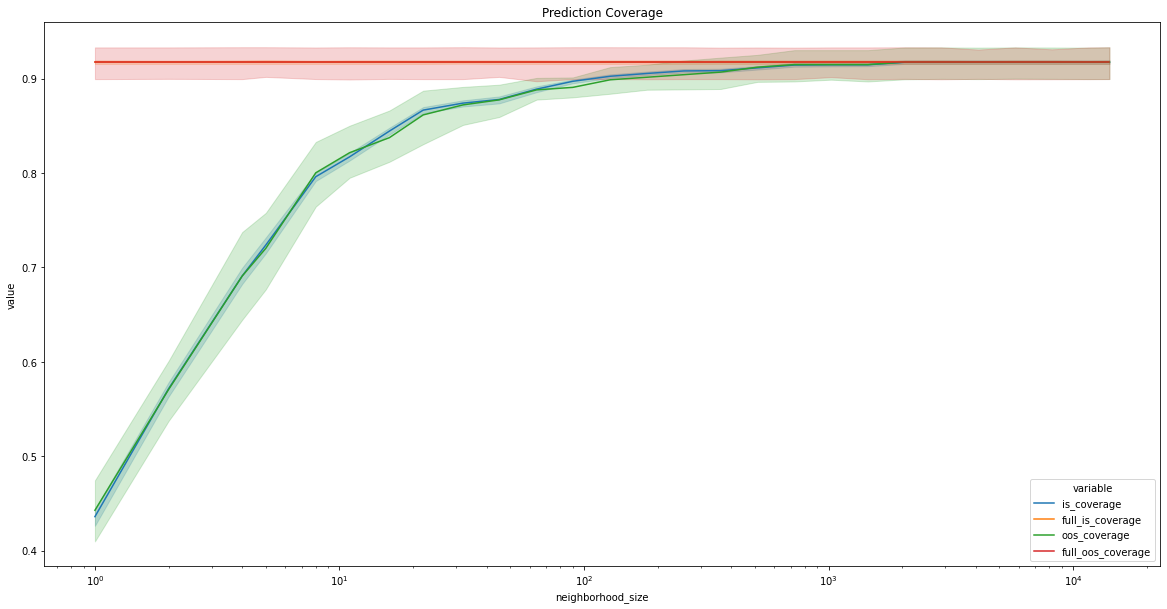

In [34]:
plt.figure(figsize=(20, 10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("coverage")],
).set(xscale="log", title="Prediction Coverage")

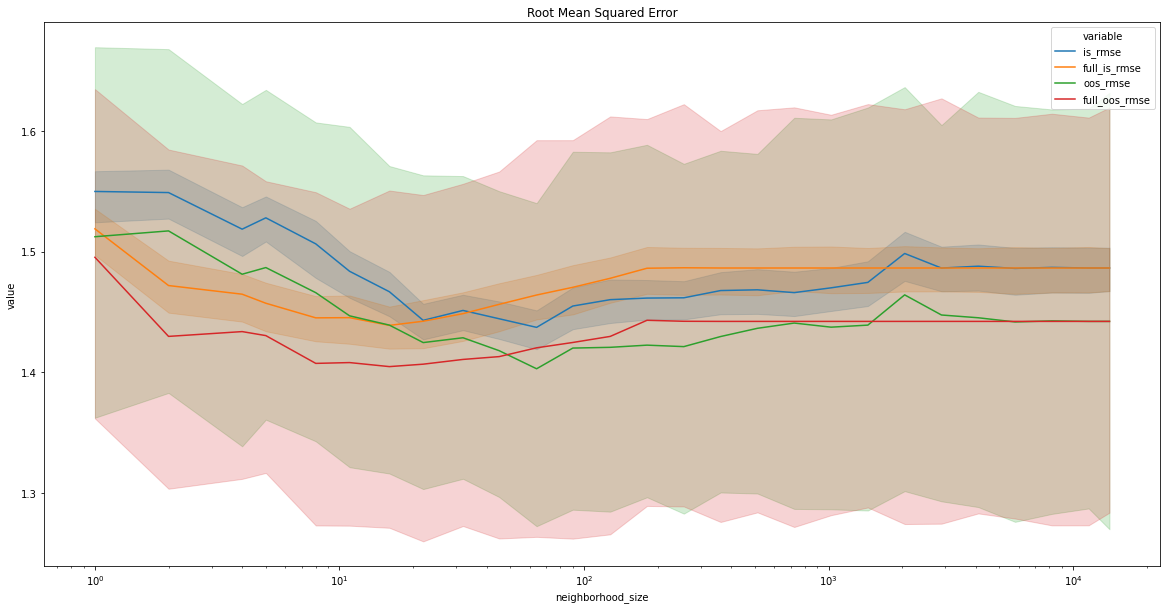

In [35]:
plt.figure(figsize=(20, 10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("rmse")],
).set(xscale="log", title="Root Mean Squared Error")

In [25]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["full_neighborhoods", "neighborhood_size"]).mean().sort_values(
    by="oos_rmse"
).head(10)

is_coverage   is_rmse  oos_coverage  oos_rmse
full_neighborhoods neighborhood_size                                               
0.0                64.0                  0.888891  1.437284      0.888122  1.402994
1.0                16.0                  0.917336  1.438925      0.917568  1.404782
                   22.0                  0.917336  1.442369      0.917568  1.406798
                   8.0                   0.917336  1.445169      0.917568  1.407450
                   11.0                  0.917336  1.445327      0.917568  1.408122
                   32.0                  0.917336  1.448642      0.917568  1.410725
                   45.0                  0.917336  1.456361      0.917568  1.413067
0.0                45.0                  0.877927  1.444408      0.877525  1.417966
                   90.0                  0.897187  1.454947      0.890754  1.420136
1.0                64.0                  0.917336  1.464067      0.917568  1.420351

In [26]:
# My takeaway from this is that it doesn't matter if we normalize variance or not
# For simplicity, let's forgo normalization

In [27]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["full_neighborhoods", "neighborhood_size"]).mean().xs(
    0, level="full_neighborhoods"
).sort_values(by="oos_rmse").head(10)

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
64.0,0.888891,1.437284,0.888122,1.402994
45.0,0.877927,1.444408,0.877525,1.417966
90.0,0.897187,1.454947,0.890754,1.420136
128.0,0.902520,1.460228,0.898791,1.420754
256.0,0.908151,1.461771,0.904196,1.421343
181.0,0.905483,1.461543,0.901494,1.422553
22.0,0.866671,1.443087,0.861593,1.424693
32.0,0.874076,1.451302,0.872191,1.428673
362.0,0.908446,1.467774,0.906899,1.429697


In [32]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["full_neighborhoods", "neighborhood_size"]).mean().xs(
    1, level="full_neighborhoods"
).sort_values(by="oos_rmse").head(10)

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
16.0,0.917336,1.438925,0.917568,1.404782
22.0,0.917336,1.442369,0.917568,1.406798
8.0,0.917336,1.445169,0.917568,1.407450
11.0,0.917336,1.445327,0.917568,1.408122
32.0,0.917336,1.448642,0.917568,1.410725
45.0,0.917336,1.456361,0.917568,1.413067
64.0,0.917336,1.464067,0.917568,1.420351
90.0,0.917336,1.470464,0.917568,1.424768
128.0,0.917336,1.477924,0.917568,1.429793
